# Attribution for recommender system model

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import scipy.sparse as sp
from torch.utils.data import DataLoader, Dataset
from captum.attr import Saliency, IntegratedGradients
import matplotlib.pyplot as plt

In [4]:
# download dataset
# url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
# !wget -q {url} -O ml-1m.zip
# !unzip -q ml-1m.zip

In [5]:
data_path = "ml-1m/ratings.dat"
movies_path = "ml-1m/movies.dat"
users_path = "ml-1m/users.dat"

data = pd.read_csv(data_path, sep="::", names=["user", "item", "rating", "timestamp"], engine="python")
movies = pd.read_csv(movies_path, sep="::", names=["item", "title", "genres"], engine="python", encoding="ISO-8859-1")
users = pd.read_csv(users_path, sep="::", names=["user", "gender", "age", "occupation", "zip"], engine="python")

In [6]:
# reindex
user_mapping = {old:new for new, old in enumerate(users["user"].unique())}
item_mapping = {old:new for new, old in enumerate(movies["item"].unique())}
data["user"] = data["user"].map(user_mapping)
data["item"] = data["item"].map(item_mapping)
movies["item"] = movies["item"].map(item_mapping)
users["user"] = users["user"].map(user_mapping)

num_users = len(user_mapping)
num_items = len(item_mapping)

In [7]:
data['rating'].values.astype(np.float32)

array([5., 3., 3., ..., 5., 4., 4.], dtype=float32)

In [8]:
# define adjacency matrix
def build_adj_matrix(data, num_users, num_items):
    rows, cols = data['user'].values, data['item'].values
    interactions = data['rating'].values.astype(np.float32)
    adj_matrix = sp.coo_matrix((interactions, (rows, cols + num_users)), 
                               shape=(num_users+num_items, num_users+num_items))
    adj_matrix = adj_matrix + adj_matrix.T # make the graph undirected
    return adj_matrix

adj_matrix = build_adj_matrix(data=data, num_users=num_users, num_items=num_items)

def normalize_adj(adj):
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return d_mat_inv_sqrt @ adj @ d_mat_inv_sqrt

adj_matrix = normalize_adj(adj_matrix)
adj_matrix = torch.FloatTensor(adj_matrix.toarray())

/var/folders/5z/8hzvmhln5p36t4tdqc9c52z40000gn/T/ipykernel_82713/1830612108.py:14: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


In [9]:
# Handle user features
gender_map = {'M':0, 'F':1}
users['gender'] = users['gender'].map(gender_map)
user_features = torch.FloatTensor(users[['gender', 'age', 'occupation']].values)

# Handle item features  
genres_set = set('|'.join(movies['genres']).split('|'))
genre_mapping = {genre: i for i, genre in enumerate(genres_set)}
movies['genres_encoded'] = movies['genres'].apply(lambda x: [genre_mapping[g] for g in x.split('|')])
movie_features = torch.zeros((num_items, len(genres_set)))
for i, row in movies.iterrows():
    for g in row['genres_encoded']:
        movie_features[row['item'], g] = 1

In [16]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, n_layers, user_feat_dim, item_feat_dim):
        super(LightGCN, self).__init__()
        # define user and item embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        # project user and item features to embedding space
        self.user_feat_fc = nn.Linear(user_feat_dim, embedding_dim) 
        self.item_feat_fc = nn.Linear(item_feat_dim, embedding_dim)
        self.n_layers = n_layers
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def forward(self, adj, user_features, item_features):
        user_feat_embed = self.user_feat_fc(user_features)
        item_feat_embed = self.item_feat_fc(item_features)
        all_embeddings = torch.cat([self.user_embedding.weight + user_feat_embed, self.item_embedding.weight + item_feat_embed], dim=0)
        embeddings = [all_embeddings]
        
        for _ in range(self.n_layers):
            all_embeddings = torch.mm(adj, all_embeddings)
            embeddings.append(all_embeddings)
        
        final_embedding = torch.mean(torch.stack(embeddings, dim=0), dim=0)
        user_final, item_final = torch.split(final_embedding, [num_users, num_items])
        return user_final, item_final

model = LightGCN(num_users, num_items, embedding_dim=64, n_layers=3, user_feat_dim=3, item_feat_dim=len(genres_set))
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss() 

def train(model, data, adj, user_features, item_features, epochs=5):
    
    model.train()
    for epoch in range(epochs):
        user_embed, item_embed = model(adj, user_features, item_features)
        loss = 0
        for user, item, rating in zip(data['user'], data['item'], data['rating']):
            user_vec = user_embed[user]
            item_vec = item_embed[item]
            score = torch.sum(user_vec * item_vec)
            loss += criterion(score, torch.tensor(float(rating)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
# train(model, data, adj_matrix, user_features, movie_features, epochs=5)
# torch.save(model.state_dict(), "lightgcn.pth")
model.load_state_dict(torch.load("lightgcn.pth"))
model.eval()

LightGCN(
  (user_embedding): Embedding(6040, 64)
  (item_embedding): Embedding(3883, 64)
  (user_feat_fc): Linear(in_features=3, out_features=64, bias=True)
  (item_feat_fc): Linear(in_features=18, out_features=64, bias=True)
)

In [17]:
target_user = 0
target_item = 0

def predict_target(user_feat_batch, movie_feat_batch, 
                   target_user, target_item, 
                   user_features=user_features, 
                   movie_features=movie_features, 
                   model=model):
    outputs = []
    B = user_feat_batch.shape[0]
    for i in range(B):
        # 取出第 i 个样本的特征，形状为 [user_feat_dim] 和 [item_feat_dim]
        cur_user_feat = user_feat_batch[i]      # [user_feat_dim]
        cur_movie_feat = movie_feat_batch[i]    # [item_feat_dim]
        
        user_features_modified = user_features.clone()
        movie_features_modified = movie_features.clone()
        
        # get the current user and movie features
        user_features_modified[target_user] = cur_user_feat
        movie_features_modified[target_item] = cur_movie_feat
        
        # Calculate embeddings and score
        user_embed, movie_embed = model(adj_matrix, user_features_modified, movie_features_modified)
        score = torch.sum(user_embed[target_user] * movie_embed[target_item])
        outputs.append(score)
    
    return torch.stack(outputs)

def wrapped_predict(user_feat, movie_feat, additional_forward_args=None):
    # print(user_feat.shape)
    return predict_target(user_feat, movie_feat, target_user, target_item)

# target_user_feat = user_features[target_user].unsqueeze(0)
# target_movie_feat = movie_features[target_item].unsqueeze(0)

# baseline_user_feat = torch.zeros_like(target_user_feat)
# baseline_movie_feat = torch.zeros_like(target_movie_feat)

# ig = IntegratedGradients(wrapped_predict)
# attributions, delta = ig.attribute(
#     inputs =  (target_user_feat, target_movie_feat),
#     baselines = (baseline_user_feat, baseline_movie_feat),
#     return_convergence_delta=True
# )

# attributions

def get_attribution(target_user, target_item, 
                    user_features=user_features, 
                    movie_features=movie_features, 
                    model=model):
    target_user_feat = user_features[target_user].unsqueeze(0)
    target_movie_feat = movie_features[target_item].unsqueeze(0)
    baseline_user_feat = torch.zeros_like(target_user_feat)
    baseline_movie_feat = torch.zeros_like(target_movie_feat)
    ig = IntegratedGradients(wrapped_predict)
    attributions, delta = ig.attribute(
        inputs =  (target_user_feat, target_movie_feat),
        baselines = (baseline_user_feat, baseline_movie_feat),
        return_convergence_delta=True
    )
    return attributions

In [ ]:
def plot_attribution(user_attr, movie_attr, top=3):
    user_feature_names = ['gender', 'age', 'occupation']
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].bar(user_feature_names, user_attr[0], color='skyblue')
    axes[0].set_xlabel("User Feature")
    axes[0].set_ylabel("Attribution Value")
    axes[0].set_title("Attribution of User Features")
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)
    
    index_to_genre = {v: k for k, v in genre_mapping.items()}
    num_movie_features = movie_attr.shape[1]
    movie_feature_names = [index_to_genre[i] for i in range(num_movie_features)]

    abs_movie_attr = np.abs(movie_attr[0])
    top_idx = np.argsort(abs_movie_attr)[-top:][::-1]
    top_values = movie_attr[0][top_idx]
    top_labels = [movie_feature_names[i] for i in top_idx]

    axes[1].bar(top_labels, top_values, color='salmon')
    axes[1].set_xlabel("Movie Genre Feature")
    axes[1].set_ylabel("Attribution Value")
    axes[1].set_title("Top 3 Important Movie Genre Features")
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [ ]:
attributions = get_attribution(target_user=0, target_item=0)

user_attr = attributions[0].detach().numpy()
movie_attr = attributions[1].detach().numpy()

plot_attribution(user_attr, movie_attr)



The result could be highly confounded.

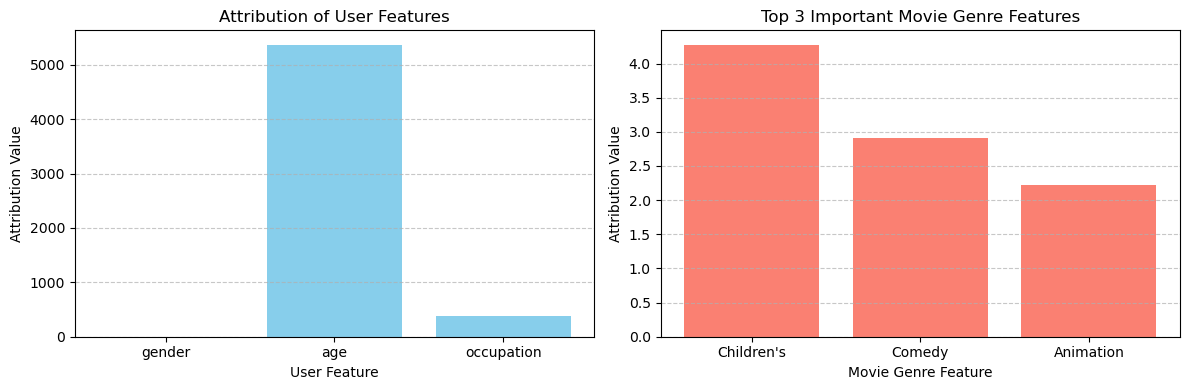

In [62]:
plot_attribution(attributions[0].detach().numpy(), attributions[1].detach().numpy())

In [ ]:
# map index back to discriptions
index_to_occ = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

index_to_genre = {v: k for k, v in genre_mapping.items()}
index_to_genre

{0: 'Adventure',
 1: 'Documentary',
 2: 'Musical',
 3: 'Comedy',
 4: 'Thriller',
 5: 'Mystery',
 6: 'Western',
 7: 'Horror',
 8: 'Film-Noir',
 9: "Children's",
 10: 'Drama',
 11: 'Action',
 12: 'Animation',
 13: 'Sci-Fi',
 14: 'Crime',
 15: 'Romance',
 16: 'Fantasy',
 17: 'War'}

In [30]:
users[users['age']==1]

,user,gender,age,occupation,zip
0,0,1,1,10,48067
18,18,0,1,10,48073
50,50,1,1,10,10562
74,74,1,1,10,01748
85,85,1,1,10,54467
...,...,...,...,...,...
5843,5843,1,1,10,02131
5952,5952,0,1,10,21030
5972,5972,0,1,10,54701
5988,5988,1,1,10,74114


In [39]:
# Predict the socre of user 0 to all the movies and find the top 5
user_index = 0
user_embed, item_embed = model(adj_matrix, user_features, movie_features)
scores = torch.matmul(user_embed[user_index], item_embed.T)
top5_scores, top5_indices = torch.topk(scores, 5)
top5_indices = top5_indices.numpy()
top5_scores = top5_scores.detach().numpy()

#visualize the top 5 movies
for i, (score, idx) in enumerate(zip(top5_scores, top5_indices)):
    movie = movies.iloc[idx]
    print
    print(f"Top {i+1} Recommendation")
    print(f"Title: {movie['title']}")
    print(f"Genres: {movie['genres']}")
    print(f"Score: {score:.4f}")
    print(f"Moview index: {idx}")
    print("\n")

Top 1 Recommendation
Title: American Beauty (1999)
Genres: Comedy|Drama
Score: 4690.6572
Moview index: 2789


Top 2 Recommendation
Title: Star Wars: Episode IV - A New Hope (1977)
Genres: Action|Adventure|Fantasy|Sci-Fi
Score: 4197.0098
Moview index: 257


Top 3 Recommendation
Title: Star Wars: Episode V - The Empire Strikes Back (1980)
Genres: Action|Adventure|Drama|Sci-Fi|War
Score: 3998.6536
Moview index: 1178


Top 4 Recommendation
Title: Saving Private Ryan (1998)
Genres: Action|Drama|War
Score: 3911.5510
Moview index: 1959


Top 5 Recommendation
Title: Star Wars: Episode VI - Return of the Jedi (1983)
Genres: Action|Adventure|Romance|Sci-Fi|War
Score: 3900.9126
Moview index: 1192




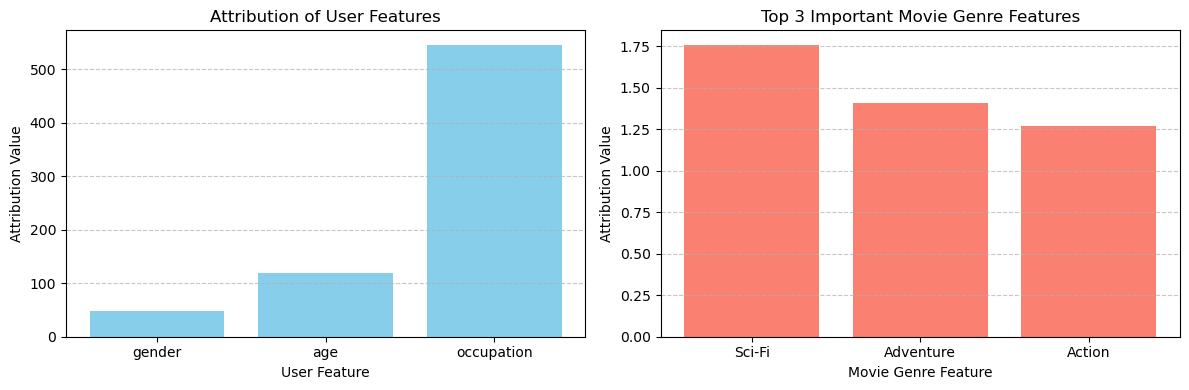

In [40]:
item_index = top5_indices[1]
attributions = get_attribution(target_user=user_index, target_item=item_index)
plot_attribution(attributions[0].detach().numpy(), attributions[1].detach().numpy())